In [1]:
!pip install scikit-learn
!pip install matplotlib seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Importa funções para dividir o conjunto de dados em treino e teste, e para busca em grade de hiperparâmetros
from sklearn.model_selection import train_test_split, GridSearchCV
# Importa ferramentas para codificação de rótulos e padronização dos dados
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Importa a classe para criar uma rede neural multilayer perceptron (MLP)
from sklearn.neural_network import MLPClassifier
# Importa métricas para avaliação de classificadores, como o relatório de classificação
from sklearn.metrics import classification_report
# Importa a matriz de confusão e o relatório de classificação
from sklearn.metrics import confusion_matrix, classification_report
# Importa funções para calcular e visualizar curvas de aprendizado
from sklearn.model_selection import learning_curve
# Importa funções para calcular a curva ROC e a área sob a curva (AUC)
from sklearn.metrics import roc_curve, auc
# Importa a matriz de confusão novamente (repetido, considerar se é necessário)
from sklearn.metrics import confusion_matrix

In [3]:
# Carregar o dataset
df = pd.read_csv('Final/Archive/data.csv')

# Limpeza dos dados
df_limpo = df.drop(columns=['id', 'Unnamed: 32'])
label_encoder = LabelEncoder()
df_limpo['diagnosis'] = label_encoder.fit_transform(df_limpo['diagnosis'])

# Separar variáveis independentes (X) e dependente (y)
X = df_limpo.drop(columns=['diagnosis'])
y = df_limpo['diagnosis']

# Normalização dos dados
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_normalizado, y, test_size=0.3, random_state=42)

# Definir a rede MLP e a grade de parâmetros
mlp = MLPClassifier(random_state=42)
grade_parametros = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],  # Neurônios nas camadas ocultas
    'activation': ['relu', 'tanh', 'logistic'],   # Funções de ativação
    'learning_rate_init': [0.001, 0.03],          # Taxas de aprendizado
    'max_iter': [100, 200]                        # Número de épocas
}

# Busca em grade com validação cruzada
grid_search = GridSearchCV(mlp, grade_parametros, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Melhor combinação de parâmetros e melhor pontuação
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Avaliação no conjunto de teste
test_score = grid_search.score(X_test, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\Anthony\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Avaliação final do modelo com as predições no conjunto de teste
y_pred = grid_search.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

def avaliar_modelo(grid_search, X_test, y_test):
    """
    Avalia o modelo treinado usando GridSearchCV, gerando gráficos de desempenho
    e exibindo um relatório de classificação.

    Parameters:
    grid_search: objeto GridSearchCV com os resultados da validação
    X_test: conjunto de dados de teste
    y_test: rótulos verdadeiros do conjunto de dados de teste
    """
    
    # Cria um DataFrame a partir dos resultados do GridSearchCV
    results = pd.DataFrame(grid_search.cv_results_)

    # Plot do desempenho de acordo com diferentes combinações de parâmetros
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='param_max_iter', y='mean_test_score', hue='param_activation', style='param_hidden_layer_sizes', data=results)
    plt.title('Desempenho médio durante a Validação Cruzada', fontsize=16)
    plt.xlabel('Número de Épocas', fontsize=12)
    plt.ylabel('Acurácia Média', fontsize=12)
    plt.legend(title='Função de Ativação e Neurônios')
    plt.grid(True)
    plt.show()

    # Gráfico da Matriz de Confusão para visualizar os resultados
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.title('Matriz de Confusão', fontsize=16)
    plt.xlabel('Predição', fontsize=12)
    plt.ylabel('Verdadeiro', fontsize=12)
    plt.show()

    # Exibe o relatório de classificação com métricas de desempenho do modelo
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['Benigno', 'Maligno']))




In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def gerar_curva_aprendizado(modelo, X_train, y_train):
    """
    Gera e plota a curva de aprendizado para o modelo fornecido.

    Parameters:
    modelo: objeto do modelo treinado
    X_train: conjunto de dados de treinamento
    y_train: rótulos do conjunto de dados de treinamento
    """
    
    # Gerar curva de aprendizado com validação cruzada
    train_sizes, train_scores, test_scores = learning_curve(
        modelo, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Calcular médias e desvios padrão
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plotar a curva de aprendizado
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Acurácia de Treino")
    plt.plot(train_sizes, test_mean, label="Acurácia de Teste")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.title("Curva de Aprendizado", fontsize=16)
    plt.xlabel("Tamanho do Conjunto de Treino", fontsize=12)
    plt.ylabel("Acurácia", fontsize=12)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plotar_curva_roc(grid_search, X_test, y_test):
    """
    Calcula e plota a curva ROC para as previsões do modelo.

    Parameters:
    grid_search: objeto GridSearchCV com o modelo treinado
    X_test: conjunto de dados de teste
    y_test: rótulos verdadeiros do conjunto de dados de teste
    """
    
    # Previsões de probabilidade para a curva ROC
    y_prob = grid_search.predict_proba(X_test)[:, 1]

    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plotar a curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Corrigir limites para 1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
    plt.title('Curva ROC', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [7]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier

# Inicializa e treina o modelo MLPClassifier
mlp_hist = MLPClassifier(random_state=42, max_iter=200, hidden_layer_sizes=(100,), activation='relu', learning_rate_init=0.001)
mlp_hist.fit(X_train, y_train)


def treinar_e_plotar_perda(X_train, y_train):
    """
    Treina um modelo MLPClassifier e plota o histórico de perda ao longo das épocas.

    Parameters:
    X_train: conjunto de dados de treinamento
    y_train: rótulos do conjunto de dados de treinamento
    """

    # Plotar o histórico de perda
    plt.figure(figsize=(8, 6))
    plt.plot(mlp_hist.loss_curve_, label="Perda")
    plt.title("Evolução da Perda ao Longo das Épocas", fontsize=16)
    plt.xlabel("Épocas", fontsize=12)
    plt.ylabel("Perda", fontsize=12)
    plt.grid(True)
    plt.legend(loc="best")
    plt.show() 
    


C:\Users\Anthony\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def prever_e_plotar_erros(grid_search, X_test, y_test):
    """
    Faz previsões no conjunto de teste, calcula os erros e plota a distribuição dos erros.

    Parameters:
    grid_search: objeto GridSearchCV com o modelo treinado
    X_test: conjunto de dados de teste
    y_test: rótulos verdadeiros do conjunto de dados de teste
    """
    
    # Prever no conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Calcular erros
    erros = y_test - y_pred

    # Plotar a distribuição dos erros
    plt.figure(figsize=(8, 6))
    sns.histplot(erros, kde=True, color="red")
    plt.title("Distribuição dos Erros", fontsize=16)
    plt.xlabel("Erro", fontsize=12)
    plt.ylabel("Frequência", fontsize=12)
    plt.grid(True)
    plt.show()

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plotar_matriz_confusao_normalizada(grid_search, X_test, y_test):
    """
    Calcula e plota a matriz de confusão normalizada para as previsões do modelo.

    Parameters:
    grid_search: objeto GridSearchCV com o modelo treinado
    X_test: conjunto de dados de teste
    y_test: rótulos verdadeiros do conjunto de dados de teste
    """
    
    # Prever no conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Matriz de Confusão Normalizada
    matriz_confusao_normalizada = confusion_matrix(y_test, y_pred, normalize='true')

    # Plotar matriz de confusão normalizada
    plt.figure(figsize=(6, 6))
    sns.heatmap(matriz_confusao_normalizada, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.title('Matriz de Confusão Normalizada', fontsize=16)
    plt.xlabel('Predição', fontsize=12)
    plt.ylabel('Verdadeiro', fontsize=12)
    plt.show()

In [10]:
def conclusao_modelo(best_params, best_score, test_score, classification_rep):
    print("\n===== Conclusão do Modelo MLP =====\n")

    # Descrição Geral
    print("1. Descrição Geral:")
    print("A rede neural MLP foi treinada e otimizada usando validação cruzada com GridSearchCV. Diversas combinações de hiperparâmetros, como o número de neurônios, funções de ativação, taxa de aprendizado e número de épocas, foram testadas para encontrar a melhor configuração.")

    # Parâmetros Otimizados
    print("\n2. Melhores Parâmetros Encontrados:")
    for param, value in best_params.items():
        print(f"   - {param}: {value}")

    # Desempenho na Validação Cruzada
    print(f"\n3. Melhor Pontuação na Validação Cruzada: {best_score:.4f}")
    print("Essa pontuação representa a acurácia média obtida durante a validação cruzada em diferentes subconjuntos de dados de treino.")

    # Desempenho no Conjunto de Teste
    print(f"\n4. Desempenho no Conjunto de Teste: {test_score:.4f}")
    print("A pontuação no conjunto de teste indica a capacidade do modelo de generalizar para dados que ele nunca viu antes.")

    # Relatório de Classificação
    print("\n5. Relatório de Classificação no Conjunto de Teste:")
    print(classification_rep)

    # Interpretação Final
    print("\n6. Interpretação Final:")
    if test_score > 0.90:
        print("O modelo apresentou um excelente desempenho, com alta acurácia tanto na validação cruzada quanto no conjunto de teste. Isso indica que ele é adequado para implementação.")
    elif test_score > 0.80:
        print("O modelo apresentou um bom desempenho, mas pode haver espaço para melhorias, como ajustar mais hiperparâmetros ou aumentar o conjunto de dados de treino.")
    else:
        print("O modelo não atingiu um desempenho satisfatório. Seria necessário investigar possíveis causas de underfitting ou overfitting e considerar ajustes mais profundos no modelo ou nos dados.")

# Chamando a função com os resultados finais do modelo
classification_rep = classification_report(y_test, grid_search.predict(X_test), target_names=['Benigno', 'Maligno'])
conclusao_modelo(best_params=best_params, best_score=best_score, test_score=test_score, classification_rep=classification_rep)



===== Conclusão do Modelo MLP =====

1. Descrição Geral:
A rede neural MLP foi treinada e otimizada usando validação cruzada com GridSearchCV. Diversas combinações de hiperparâmetros, como o número de neurônios, funções de ativação, taxa de aprendizado e número de épocas, foram testadas para encontrar a melhor configuração.

2. Melhores Parâmetros Encontrados:
   - activation: tanh
   - hidden_layer_sizes: (10,)
   - learning_rate_init: 0.03
   - max_iter: 100

3. Melhor Pontuação na Validação Cruzada: 0.9748
Essa pontuação representa a acurácia média obtida durante a validação cruzada em diferentes subconjuntos de dados de treino.

4. Desempenho no Conjunto de Teste: 0.9825
A pontuação no conjunto de teste indica a capacidade do modelo de generalizar para dados que ele nunca viu antes.

5. Relatório de Classificação no Conjunto de Teste:
              precision    recall  f1-score   support

     Benigno       0.99      0.98      0.99       108
     Maligno       0.97      0.98      

In [11]:
# Função para gerar e exibir todos os gráficos e relatórios
def gerar_graficos(mlp, X_train, y_train, X_test, y_test, grid_search, mlp_hist, best_params, best_score, test_score):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
    from sklearn.model_selection import learning_curve
    import numpy as np

    
    # 1. Gráfico de treinamento e validação (usando os resultados do GridSearchCV)
    avaliar_modelo(grid_search, X_test, y_test)
    
    # 2. Curva de Aprendizado (Desempenho médio durante a validação cruzada)
    gerar_curva_aprendizado(mlp, X_train, y_train)
        
    # 3. Matriz de Confusão Normalizada
    plotar_matriz_confusao_normalizada(grid_search, X_test, y_test)

    # 4. Treinar e plotar perda
    treinar_e_plotar_perda(X_train, y_train)

    # 5. Prever e plotar erros
    prever_e_plotar_erros(grid_search, X_test, y_test)
    
    # 6. Curva ROC
    plotar_curva_roc(grid_search, X_test, y_test)

    # 6. Relatório de Classificação
    classification_rep = classification_report(y_test, y_pred, target_names=['Benigno', 'Maligno'])
    print("\nRelatório de Classificação:\n", classification_rep)
    print("Melhores Parâmetros:", best_params)
    print("Melhor Pontuação na Validação Cruzada:", best_score)
    print("Pontuação no Conjunto de Teste:", test_score)
    
    # 7. Conclusão do modelo MLP
    conclusao_modelo(best_params=best_params, best_score=best_score, test_score=test_score, classification_rep=classification_rep)


C:\Users\Anthony\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Anthony\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


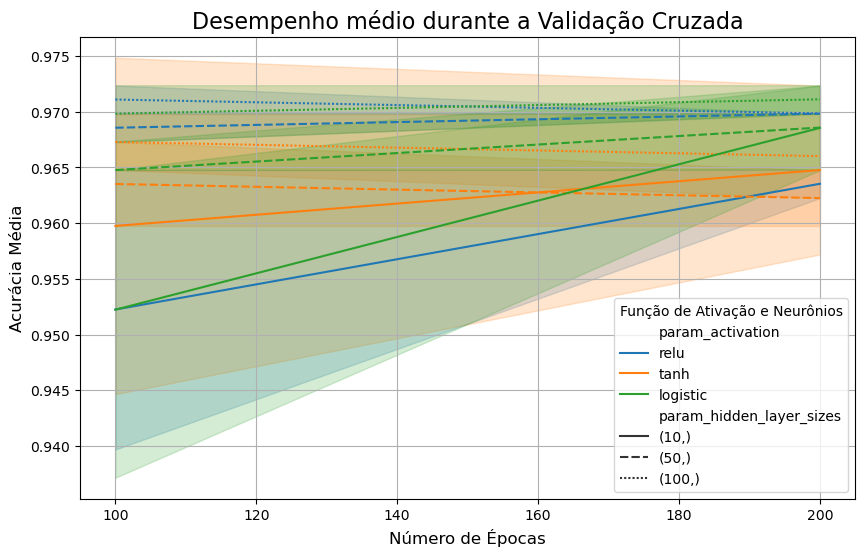

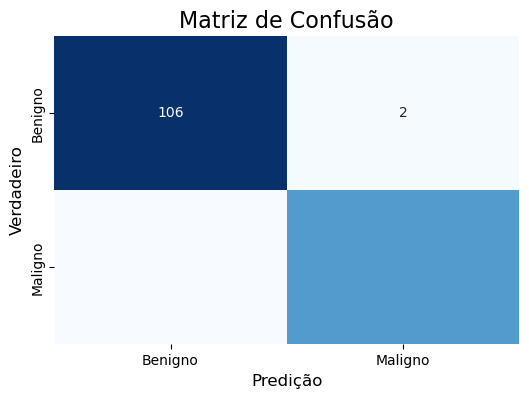

Relatório de Classificação:
              precision    recall  f1-score   support

     Benigno       0.99      0.98      0.99       108
     Maligno       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



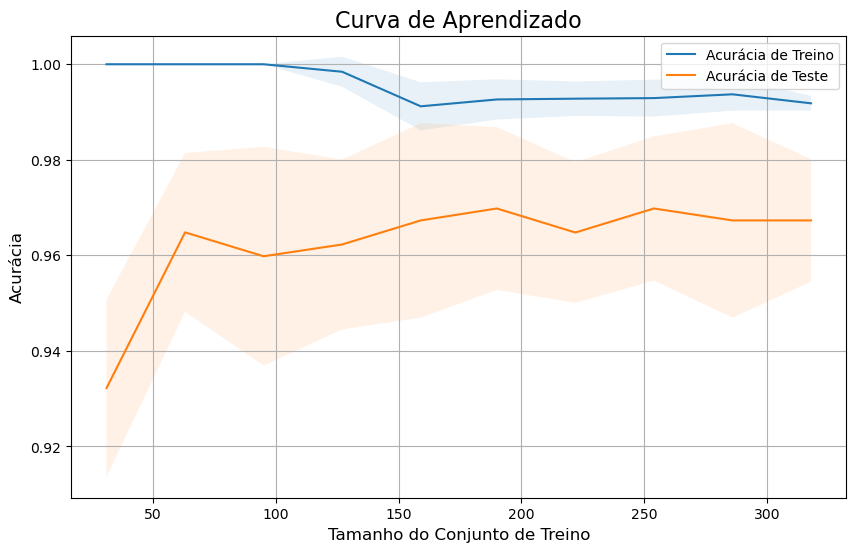

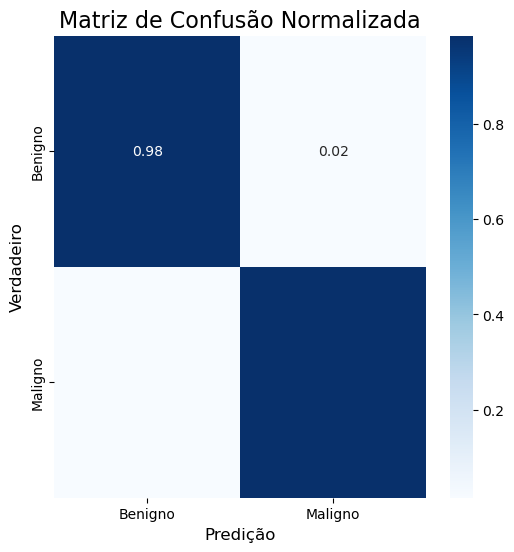

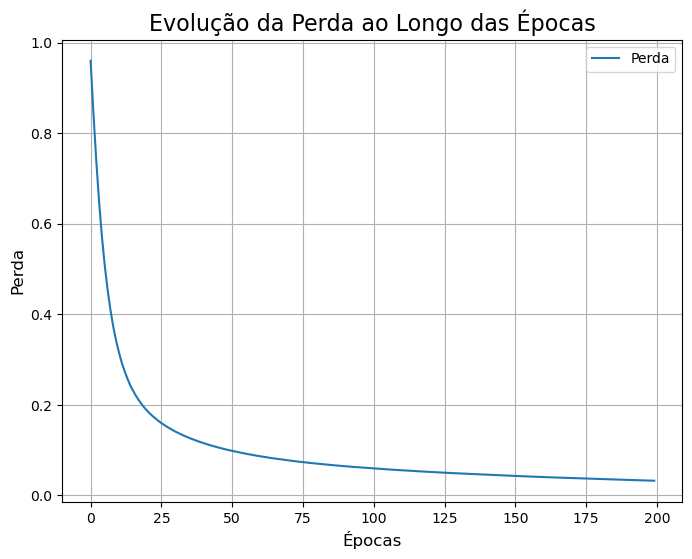

C:\Users\Anthony\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


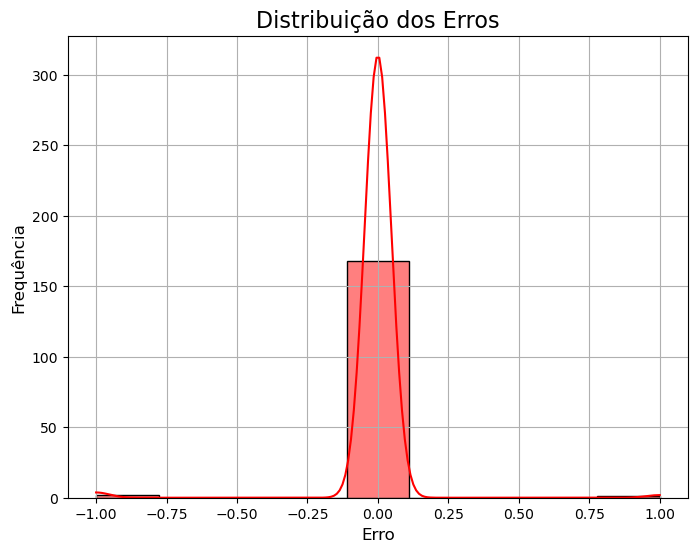

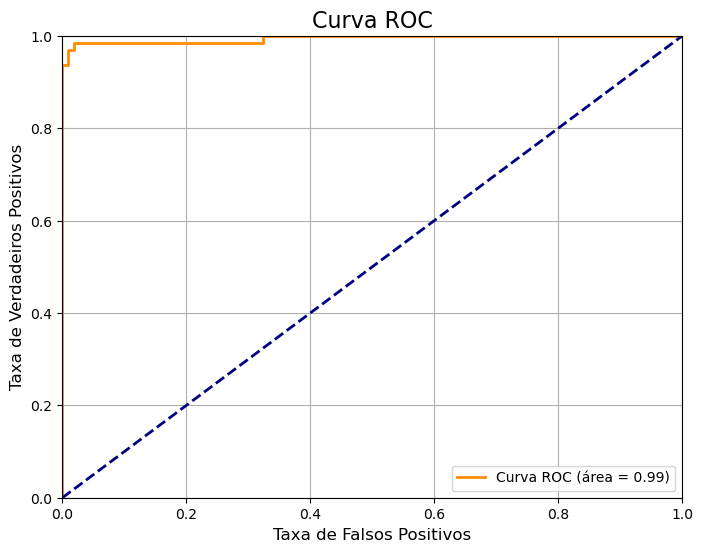


Relatório de Classificação:
               precision    recall  f1-score   support

     Benigno       0.99      0.98      0.99       108
     Maligno       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Melhores Parâmetros: {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.03, 'max_iter': 100}
Melhor Pontuação na Validação Cruzada: 0.9748417721518987
Pontuação no Conjunto de Teste: 0.9824561403508771

===== Conclusão do Modelo MLP =====

1. Descrição Geral:
A rede neural MLP foi treinada e otimizada usando validação cruzada com GridSearchCV. Diversas combinações de hiperparâmetros, como o número de neurônios, funções de ativação, taxa de aprendizado e número de épocas, foram testadas para encontrar a melhor configuração.

2. Melhores Parâmetros Encontrados:
   - activation: tanh
   - hidden_layer_sizes: (10,)

In [12]:
# chamar todos os parametros e visualizar os graficos em sequencia:
gerar_graficos(mlp, X_train, y_train, X_test, y_test, grid_search, mlp_hist, best_params, best_score, test_score)

In [13]:
"""
Função se quiser salvar os graficos para exporta-los
def gerar_graficos_e_salvar(mlp, X_train, y_train, X_test, y_test, busca_grade, best_params, best_score, test_score, folder_path='resultados/'):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
    from sklearn.model_selection import learning_curve
    import numpy as np
    import os

    # Criar a pasta se não existir
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # 1. Curva de Aprendizado
    train_sizes, train_scores, test_scores = learning_curve(mlp, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Acurácia de treino")
    plt.plot(train_sizes, test_mean, label="Acurácia de teste")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.title("Curva de Aprendizado")
    plt.xlabel("Tamanho do Conjunto de Treino")
    plt.ylabel("Acurácia")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(os.path.join(folder_path, 'curva_aprendizado.png'))
    plt.close()

    # 2. Matriz de Confusão
    y_pred = busca_grade.predict(X_test)
    matriz_confusao = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.title("Matriz de Confusão")
    plt.xlabel("Predição")
    plt.ylabel("Verdadeiro")
    plt.savefig(os.path.join(folder_path, 'matriz_confusao.png'))
    plt.close()

    # 3. Relatório de Classificação
    classification_rep = classification_report(y_test, y_pred, target_names=['Benigno', 'Maligno'])
    with open(os.path.join(folder_path, 'relatorio_classificacao.txt'), 'w') as f:
        f.write(classification_rep)

    # 4. Curva ROC
    # Previsões de probabilidade para a curva ROC
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plotar a curva ROC
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 10], [0, 10], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 10.00])
    plt.ylim([0.0, 10.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    # 5. Evolução da Perda ao longo das épocas
    mlp_hist = MLPClassifier(random_state=42, max_iter=200, hidden_layer_sizes=(100,), activation='relu', learning_rate_init=0.001)
    mlp_hist.fit(X_train, y_train)

    # Plotar o histórico de perda
    plt.figure(figsize=(8, 6))
    plt.plot(mlp_hist.loss_curve_, label="Perda")
    plt.title("Evolução da Perda ao Longo das Épocas", fontsize=16)
    plt.xlabel("Épocas", fontsize=12)
    plt.ylabel("Perda", fontsize=12)
    plt.grid(True)
    plt.legend(loc="best")
    plt.savefig(os.path.join(folder_path, 'evolucao_perda.png'))
    plt.close()

    # 6. Distribuição dos Erros
    erros = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(erros, kde=True, color="red")
    plt.title("Distribuição dos Erros")
    plt.xlabel("Erro")
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.savefig(os.path.join(folder_path, 'distribuicao_erros.png'))
    plt.close()

    # 7. Matriz de Confusão Normalizada
    matriz_confusao_normalizada = confusion_matrix(y_test, y_pred, normalize='true')

    plt.figure(figsize=(6, 6))
    sns.heatmap(matriz_confusao_normalizada, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Benigno', 'Maligno'], yticklabels=['Benigno', 'Maligno'])
    plt.title('Matriz de Confusão Normalizada')
    plt.xlabel('Predição')
    plt.ylabel('Verdadeiro')
    plt.savefig(os.path.join(folder_path, 'matriz_confusao_normalizada.png'))
    plt.close()

    # 8. Conclusão do modelo
    with open(os.path.join(folder_path, 'conclusao_modelo.txt'), 'w') as f:
        f.write(f"Melhores Parâmetros: {best_params}\n")
        f.write(f"Melhor Acurácia no Treino: {best_score}\n")
        f.write(f"Acurácia no Teste: {test_score}\n")

gerar_graficos_e_salvar(mlp=mlp,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test,
                        y_test=y_test,
                        busca_grade=grid_search,
                        best_params=best_params,
                        best_score=best_score,
                        test_score=test_score,
                        folder_path='meu_diretorio/')

"""

'\nFunção se quiser salvar os graficos para exporta-los\ndef gerar_graficos_e_salvar(mlp, X_train, y_train, X_test, y_test, busca_grade, best_params, best_score, test_score, folder_path=\'resultados/\'):\n    import matplotlib.pyplot as plt\n    import seaborn as sns\n    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc\n    from sklearn.model_selection import learning_curve\n    import numpy as np\n    import os\n\n    # Criar a pasta se não existir\n    if not os.path.exists(folder_path):\n        os.makedirs(folder_path)\n\n    # 1. Curva de Aprendizado\n    train_sizes, train_scores, test_scores = learning_curve(mlp, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))\n    train_mean = np.mean(train_scores, axis=1)\n    test_mean = np.mean(test_scores, axis=1)\n    train_std = np.std(train_scores, axis=1)\n    test_std = np.std(test_scores, axis=1)\n\n    plt.figure(figsize=(8, 6))\n    plt.plot(train_sizes, train_mean, label